In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
#im skipping leap days currently in multiple places
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random
import json
import pickle
import time
import copy

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
#ercot 2017 loads

path = "/home/jimin/chase/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")

testloads = np.array(list(ercot2017['ERCOT']))

In [5]:
startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)
    
trainhours = np.array(allhours[0:-8760]) #all but last year, not a leap year
testhours = np.array(allhours[-8760:])

#get indecies of day starts in testhours
startdate = datetime.datetime(year=2017, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

day_start_i = []
i = 0

while curr < enddate:
    if curr.hour == 0:
        day_start_i.append(i)
    curr += datetime.timedelta(hours=1)
    i += 1


array([datetime.datetime(2017, 7, 28, 15, 0),
       datetime.datetime(2017, 7, 28, 16, 0),
       datetime.datetime(2017, 7, 28, 14, 0),
       datetime.datetime(2017, 7, 20, 15, 0),
       datetime.datetime(2017, 7, 27, 15, 0)], dtype=object)

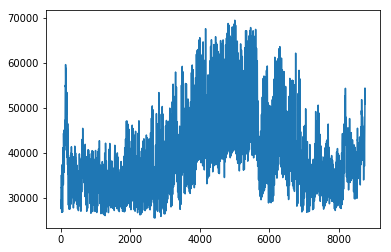

In [6]:
#July peak was calculated to have occured at datetime.datetime(2017, 7, 28, 17, 0)

plt.plot(testloads)
testhours[testloads.argsort()[-5:][::-1]]

In [10]:
print(testloads.argsort()[-5:][::-1])

[5007 5008 5006 4815 4983]


In [5]:
#percentage difference in top two
print(testloads.argsort()[-4:][::-1])
testloads[5007] - testloads[4815] #largest loads exceeds second largest load by 722.3 MW

#average peak was 67,273.1 MW
print(722.3/67273.1) 

#1% of load reduction would result in peak time shift, so I can consider a business using up to approx 700 MW in 2017 without annual peak occuring at some other time

#per ERCOT Day-ahead load forecast error for July was 2.27%

[5007 5008 5006 4815]
0.010736832404036679


In [6]:
#lmps
xls = pd.ExcelFile(path + "LMPS/rpt.00013060.0000000000000000.DAMLZHBSPP_2016.xlsx")
sheets_2016 = ["Jan_1", "Feb_2", "Mar_3", "Apr_4", "May_5", "Jun_6", "Jul_7", "Aug_8", "Sep_9", "Oct_10", "Nov_11", "Dec_12"]
hourly_lmp_2016 = []
for sheet in sheets_2016:
    lmps = pd.read_excel(xls, sheet)
    for i in range(len(lmps['Settlement Point Price'])):
        if lmps['Settlement Point'][i] == 'HB_BUSAVG':
            hourly_lmp_2016.append(lmps['Settlement Point Price'][i])
            
xls = pd.ExcelFile(path + "LMPS/rpt.00013060.0000000000000000.DAMLZHBSPP_2017.xlsx")
sheets_2017 = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
hourly_lmp = []
for sheet in sheets_2017:
    lmps = pd.read_excel(xls, sheet)
    for i in range(len(lmps['Settlement Point Price'])):
        if lmps['Settlement Point'][i] == 'HB_BUSAVG':
            hourly_lmp.append(lmps['Settlement Point Price'][i])
            
hourly_lmp = np.array(hourly_lmp)

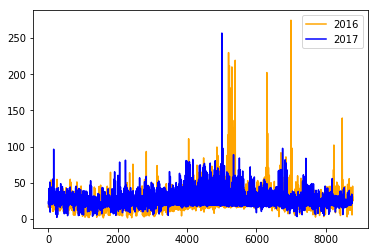

In [7]:
#per megawatt price
plt.plot(hourly_lmp_2016, color="orange", label="2016")
plt.plot(hourly_lmp, color="blue", label="2017")
plt.legend()

In [8]:
#peak lmp's occured 
print(hourly_lmp[[5007, 5008, 5006]])

[206.47  59.55 257.04]


In [44]:
print(testhours[hourly_lmp.argsort()[-5:][::-1]])

NameError: name 'hourly_lmp' is not defined

In [10]:
#concave utility function from 0 to 500 MW
#500 MW at $2150 per MW CP costs = 1.075mil per annum
#maximum daily utility set equal to transmission costs
#17.5(x)(500 - x) - (pi_e + pi_cp)x = y utility
#-17.5x^2 + [8750 - (pi_e + pi_cp)]x = y
#dy/dx = -35x + [8750 - (pi_e + pi_cp)], max x = [8750 - (pi_e + pi_cp)]/35


cp_perMW = 2150.0

In [7]:
#generate historical average model

570.2781314827644 36556.5790095115


/home/jimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


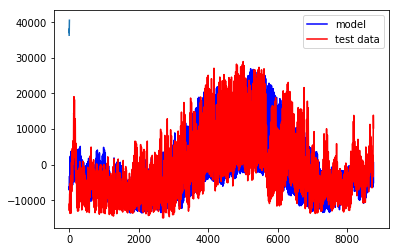

In [7]:
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/jimin/chase/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]

#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]
    
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
plt.plot(model, color="blue", label="model")
plt.plot(test, color="red", label="test data")
plt.legend()
plt.show()

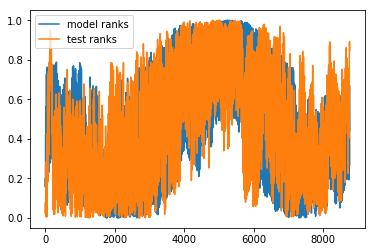

In [8]:
model_ranks = np.zeros((yearly_loads.shape[1], 1))
test_ranks = np.zeros((yearly_loads.shape[1], 1))

for i in range(model_ranks.shape[0]):
    greater = np.sum([ 1 for k in model[:,] if k >= model[i,] ])/float(model.shape[0])
    model_ranks[i,0] = 1.0 - greater
    
for i in range(test_ranks.shape[0]):
    greater = np.sum([ 1 for k in test[:,] if k >= test[i,] ])/float(test.shape[0])
    test_ranks[i,0] = 1.0 - greater
    
plt.plot(model_ranks, label="model ranks")
plt.plot(test_ranks, label="test ranks")
plt.legend()

In [10]:
#marginal utility model
def cp_curtailment(cdfval, min_thresh=0.85):
    #returns a fractional curtailment of power demand as a function
    #of predicted CDF value of load
    curtail_val = (cdfval - min_thresh)/(1 - min_thresh)
    outval = np.nanmax([0, curtail_val])
    return(outval)

historical_by_alpha = []
top_k = 10
top_i = testloads.argsort()[-top_k:][::-1]
power_range = np.arange(0,500.05,0.05)
cp_cost = 1.6
alphas = np.arange(0.85,1.001,0.001)

for a in alphas:
    ann_util = 0.0

    for i in day_start_i:
        dt = testhours[i]
        if dt.weekday() == 5 or dt.weekday() == 6:
            pass
        #for h in range(24):
        else:
            cdf_vals = model_ranks[i:i+24]
            for h in range(9,17):
                ann_hour = i+h
                curtail_mp = cp_curtailment(cdf_vals[h], min_thresh=a)
                optim_vals = 1.61*np.log(1 + power_range) - curtail_mp*cp_cost*power_range
                opt = power_range[np.argmax(optim_vals)]
                if ann_hour in top_i:
                    util = 1.61*np.log(1 + opt) - cp_cost*opt
                    ann_util += util
                else:
                    util = 1.61*np.log(1 + opt)
                    ann_util += util

    #print(ann_util/ann_util_opt)
    historical_by_alpha.append(ann_util)

/home/jimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [11]:
#lost utility due to curtailment

lost_historical_by_alpha = []

for a in alphas:
    ann_util = 0.0

    for i in day_start_i:
        dt = testhours[i]
        cdf_vals = model_ranks[i:i+24]
        #for h in range(24):
        for h in range(9,17):
            ann_hour = i+h
            if ann_hour not in top_i:
                curtail_mp = cp_curtailment(cdf_vals[h], min_thresh=a)
                ann_util += curtail_mp
            
            if ann_hour == 5007:
                peak = cdf_vals[h]
            #    ann_util += curtail_mp*(100)
            #else:
            #    ann_util += curtail_mp

    #print(ann_util/ann_util_opt)
    lost_historical_by_alpha.append(ann_util)
print(peak)

[0.9859589]


/home/jimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [45]:
#perfect knowledge curtailment
opt_by_alpha = []
ann_util = 0.0

for i in day_start_i:
    dt = testhours[i]
    if dt.weekday() == 5 or dt.weekday() == 6:
        pass
    else:
        for h in range(9,17):
            ann_hour = i+h
            if ann_hour in top_i:
                optim_vals = 1.61*np.log(1 + power_range) - cp_cost*power_range
                opt = power_range[np.argmax(optim_vals)]
                ann_util += 1.61*np.log(1 + opt) - cp_cost*opt
            else:
                util = 1.61*np.log(1.0 + 500.0)
                ann_util += util
                
for a in alphas:
    opt_by_alpha.append(ann_util)
    
print(ann_util)

20728.09188890808


In [16]:
#no activity lost utility

naive_by_alpha = []
ann_util = 0.0

for i in day_start_i:
    dt = testhours[i]
    if dt.weekday() == 5 or dt.weekday() == 6:
        pass
    else:
        for h in range(9,17):
            ann_hour = i+h
            if ann_hour in top_i:
                util = 1.61*np.log(1.0 + 500.0) - cp_cost*500.0
                ann_util += util
            else:
                util = 1.61*np.log(1.0 + 500.0)
                ann_util += util
                
for a in alphas:
    naive_by_alpha.append(ann_util)
    
print(ann_util)


13618.170511312795


In [18]:
#neural net model
#with weather data
def torch_reshape_data(databatch):
    #flattens array inputs for a single list of training, target pairs
    inputs = []
    labels = []
    for sample in databatch:
        inputs.append(sample[0].flatten())
        labels.append(sample[1].flatten())
    return(torch.Tensor(np.asarray(inputs)), torch.Tensor(np.asarray(labels)))

path = "/home/jimin/chase/peakload/data/nets/models/"
#mname = 'triple_hidden_1903.pt'
#mname = 'triple_hidden_3224.pt'
mname = 'tanh_deep_1863.pt'
#mname = 'triple_hidden_3080.pt'
#mname = 'triple_hidden_3120.pt' #L1 weather loss
#mname = 'triple_hidden_6772.pt' #load data only

sys.path.append("/home/jimin/chase/peakload/src/python/nets/tanh_deep")

nnmodel = torch.load(path + mname)

random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

#test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/regional_formatted/load_features/test"#
test_data_path = "/home/jimin/chase/peakload/data/load_features_wplus/test"
#test_data_path = "/home/chase/projects/peakload/data/ercot/regional_formatted/load_features/test"
files = os.listdir(test_data_path)
weather_normed_test_data_pairs = []

for i in range(8735):
    fname = str(i) + "_all_weather_load_features.pck"
    with open(test_data_path + "/" + fname, 'rb') as d:
        weather_normed_test_data_pairs.append(pickle.load(d))

In [19]:
day_pairs = []

for i in day_start_i:
    try:
        day_pairs.append(weather_normed_test_data_pairs[i])
    except:
        pass

In [20]:
#do prediction on test data
inputs, labels = torch_reshape_data(day_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()
inputs = inputs.data.cpu().numpy()

In [24]:
x = []
y = []
pairs = []

for i in range(outputs.shape[0]):
    daystart = i*24
    if i == 364:
        break
    cdf_vals = outputs[i,:]
    powers = testloads[daystart:daystart+24,]
    
    #x.append(powers)
    #y.append(cdf_vals)
    
    for k in range(len(powers)):
        x.append(powers[k])
        y.append(cdf_vals[k])
    #    pairs.append((powers[k],cdf_vals[k]))

In [25]:
len(x)

8736

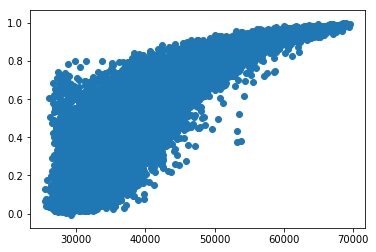

In [26]:
plt.scatter(x,y)

In [21]:
#marginal utility model

nn_by_alpha = []

for a in alphas:
    nn_ann_util = 0.0

    j = 0
    for i in day_start_i:
        dt = testhours[i]
        if j == 364:
            nn_ann_util += 10
            break
        if dt.weekday() == 5 or dt.weekday() == 6:
            pass
        else:
            cdf_vals = outputs[j,:]
            #for h in range(24):
            for h in range(9,17):
                ann_hour = i+h
                curtail_mp = cp_curtailment(cdf_vals[h], min_thresh=a)
                if curtail_mp > 1.0:
                    curtail_mp = 1.0
                optim_vals = 1.61*np.log(1 + power_range) - curtail_mp*cp_cost*power_range
                opt = power_range[np.argmax(optim_vals)]
                    #print("over")
                if ann_hour in top_i:
                    util = 1.61*np.log(1 + opt) - cp_cost*opt
                    nn_ann_util += util
                else:
                    util = 1.61*np.log(1 + opt)
                    nn_ann_util += util
                if ann_hour == 5007:
                    peak = cdf_vals[h]

        j += 1

    nn_by_alpha.append(nn_ann_util)
print(peak)
    #print(nn_ann_util/ann_util_opt)

/home/jimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


0.9923022


In [22]:
#lost marginal utility model

lost_nn_by_alpha = []

for a in alphas:
    nn_ann_util = 0.0
    hourly_utils = []

    j = 0
    for i in day_start_i:
        dt = testhours[i]
        if j == 364:
            nn_ann_util += 1
            break
        cdf_vals = outputs[j,:]
        #for h in range(24):
        for h in range(9,17):
            ann_hour = i+h
            if ann_hour not in top_i:
                curtail_mp = cp_curtailment(cdf_vals[h], min_thresh=a)
                nn_ann_util += curtail_mp
            #if curtail_mp > 1.0:
            #    curtail_mp = 1.0
                #print("over")
            #if ann_hour == 5007:
            #    nn_ann_util += curtail_mp*(-0.1)
            #else:
            #    nn_ann_util += curtail_mp

        j += 1

    lost_nn_by_alpha.append(nn_ann_util)
    #print(nn_ann_util/ann_util_opt)

/home/jimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


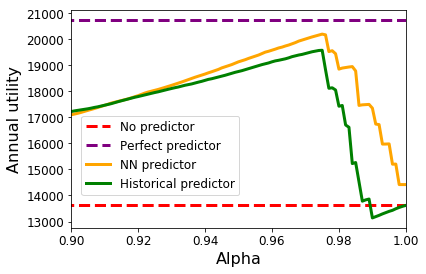

In [57]:

#plt.title("Annual utility as function of curtailment threshold")
plt.plot(alphas, naive_by_alpha, color="red", ls='--', lw=3, label="No predictor")
plt.plot(alphas, opt_by_alpha, color="purple", ls='--', lw=3, label="Perfect predictor")
plt.plot(alphas, nn_by_alpha, color="orange", lw=3, label="NN predictor")
plt.plot(alphas, historical_by_alpha, color="green", lw=3, label="Historical predictor")
plt.xlabel("Alpha", fontsize=16)
plt.ylabel("Annual utility", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0.9,1)
#plt.ylim(0,3500)
#plt.xlim(0.98,1)

plt.legend(fontsize=12,loc=(0.03,0.15))#'lower left')

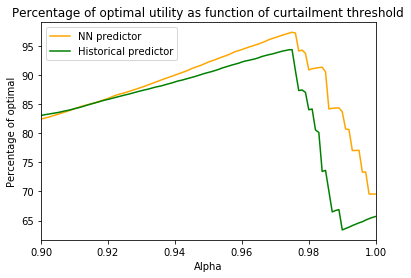

In [28]:
plt.title("Percentage of optimal utility as function of curtailment threshold")
plt.plot(alphas, (np.array(nn_by_alpha)/np.array(opt_by_alpha))*100.0, color="orange", label="NN predictor")
plt.plot(alphas, (np.array(historical_by_alpha)/np.array(opt_by_alpha))*100.0, color="green", label="Historical predictor")
plt.xlabel("Alpha")
plt.ylabel("Percentage of optimal")
plt.xlim(0.9,1)
#plt.ylim(0,3500)
#plt.xlim(0.98,1)

plt.legend()

Text(0,0.5,'Annual utility difference')

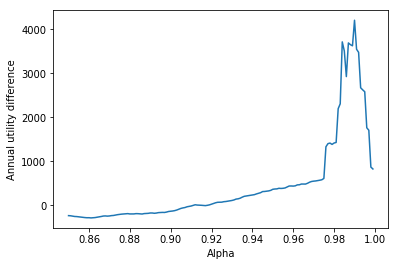

In [88]:
plt.plot(alphas, np.array(nn_by_alpha) - np.array(historical_by_alpha))
plt.xlabel("Alpha")
plt.ylabel("Annual utility difference")

In [36]:
print(np.array(nn_by_alpha) - np.array(historical_by_alpha))

[100.49720056 100.78811201 101.07449257 101.37605383 101.69948858
 102.02302804 102.35964285 102.70961357 103.08180142 103.46382799
 103.85964918 104.25610441 104.67802133 105.10461213 105.53577811
 105.96522487 106.39252163 106.80606345 107.20039123 107.58344197
 107.99522051 108.41905149 108.82798186 109.24601419 109.65225018
 110.04714257 110.4312984  110.80931136 111.18214484 111.55224913
 111.90804331 112.28868139 112.67838628 113.08228927 113.46892902
 113.8569341  114.26283516 114.70134749 115.12509107 115.55076462
 115.98512687 116.3980594  116.80958485 117.26433736 117.72339864
 118.16225662 118.60735188 119.06037112 119.54081191 120.02069347
 120.47592646 120.93626426 121.40490111 121.87973962 122.34211511
 122.78312018 123.1870982  123.57378972 123.95992288 124.31018374
 124.65076315 124.98848683 125.29669599 125.55148078 125.83015715
 126.12133    126.42885501 126.7645433  127.14461507 127.52670368
 127.90559061 128.26445407 128.58970704 128.87890725 129.13868183
 129.40975

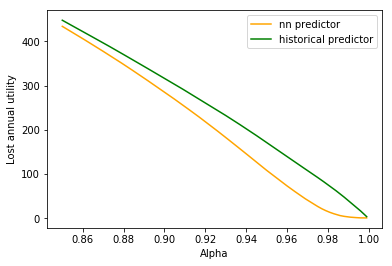

In [89]:
#plt.plot(alphas, perfect, color="blue", label="perfect predictor")
plt.plot(alphas, lost_nn_by_alpha, color="orange", label="nn predictor")
plt.plot(alphas, lost_historical_by_alpha, color="green", label="historical predictor")
plt.xlabel("Alpha")
plt.ylabel("Total annual curtailment")
#plt.ylim(2000,3500)

plt.legend()

In [48]:
np.array(lost_historical_by_alpha) - np.array(lost_nn_by_alpha)

array([13.77212985, 13.95308718, 14.13980031, 14.33312137, 14.54289254,
       14.73113181, 14.93260501, 15.15166518, 15.40803811, 15.67981538,
       15.9626745 , 16.23334439, 16.51724456, 16.81828952, 17.13212377,
       17.4528292 , 17.78119795, 18.10589373, 18.41048885, 18.70917536,
       19.03552501, 19.37100662, 19.6993654 , 20.04333482, 20.37530957,
       20.70065015, 21.01674607, 21.33035628, 21.64206496, 21.96166618,
       22.28049493, 22.63759323, 23.01633335, 23.42308465, 23.82933939,
       24.24175235, 24.65863324, 25.09986998, 25.53813556, 25.98306222,
       26.42589183, 26.85433026, 27.2783613 , 27.75630161, 28.25852331,
       28.73459337, 29.20104247, 29.68202335, 30.18214316, 30.65520808,
       31.12150587, 31.61416905, 32.14298256, 32.71040373, 33.27634619,
       33.82492662, 34.34356661, 34.8736812 , 35.43032119, 35.96607822,
       36.49589875, 37.05597666, 37.60583383, 38.12573317, 38.66326418,
       39.23269536, 39.83050872, 40.4868167 , 41.19438065, 41.91

In [1]:
#plt.plot(alphas, perfect, color="blue", label="perfect predictor")
plt.plot(alphas, (np.array(nn_by_alpha)/20000)*100, color="orange", label="nn predictor")
plt.plot(alphas, (np.array(historical_by_alpha)/20000)*100, color="green", label="historical predictor")
plt.xlabel("Alpha")
plt.ylabel("Percentage of perfect predictor")
#plt.ylim(80,100)
plt.xlim(0.9, 1)
#plt.axvline(x=0.9988)
plt.legend()

NameError: name 'plt' is not defined

In [65]:
np.array(nn_by_alpha) - np.array(historical_by_alpha)

array([249.88909093, 248.70542643, 247.53991739, 246.40187252,
       245.26557466, 244.1176187 , 242.96030237, 241.81014229,
       240.66317493, 239.51545449, 238.38006868, 237.22752628,
       236.0811546 , 234.94072329, 233.79810296, 232.67254262,
       231.54755632, 230.41701493, 229.27281633, 228.13402882,
       227.00066893, 225.85164095, 224.6951766 , 223.5364547 ,
       222.36024163, 221.15765479, 219.94471586, 218.72085253,
       217.49800152, 216.2607742 , 215.00374555, 213.74481486,
       212.48391755, 211.20301108, 209.93531542, 208.69043356,
       207.42421406, 206.15111644, 204.89534741, 203.64868856,
       202.38150429, 201.08911674, 199.76312946, 198.44603246,
       197.12473945, 195.81352429, 194.50985728, 193.1995915 ,
       191.87215642, 190.52941743, 189.18047   , 187.85001662,
       186.54161169, 185.19123631, 183.81997632, 182.44507711,
       181.02232936, 179.56681436, 178.10344512, 176.58058759,
       175.01847476, 173.4760858 , 171.92417863, 170.34

In [28]:
alphas

array([0.85 , 0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 ,
       0.895, 0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935,
       0.94 , 0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 ,
       0.985, 0.99 , 0.995])